# AutoEncoder Hyperparameter Tuning

This notebook documents the steps for experimenting with and selecting hyperparameters for training the AutoEncoder. We will load the data, define hyperparameters, train the model, evaluate performance, and visualize results.

## 1. Load Required Libraries

We will start by loading the necessary libraries.

In [1]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from autoencoder import AutoEncoder
from dataSamplization import DataSamplization
from autoEncoderTrainingLoop import autoEncoderTraining
from dataBatching import dataBatching

## 2. Load Data

Next, we will load the sample data that will be used for training and testing the AutoEncoder.

In [2]:
# Load the dataset
dataSamplization = DataSamplization(sampleNum=1000, modelBinPath='modelsSavedLocally/cc.fr.300.bin', csvSavePath='data/')

Loading saved FastText model...


In [ ]:
# Take data from random words of the vocabulary if prefered
data = dataSamplization.randomWordsDataSample()
print([data[10:]])

In [3]:
# Take data from most-used words if prefered
data = dataSamplization.mostUsedDataSample()
print([data[10:]])

Vocabulary sample saved into vocabulary_sample.csv
[['Elle', '15', 'également', 'Re', 'contre', 'Vous', 'c', 'moins', 'tu', 'suis', '7', 'ville', 'avait', 'vos', 'vers', 'premier', 'vie', 'Et', '2016', '2014', 'jour', '00', '2013', 'leurs', 'Dans', 'soit', '2012', 'toutes', 'nom', '2015', '14', 'De', 'On', '8', 'prix', '18', "C'", 'Mais', 'partie', '•', 'nos', 'voir', 'article', '16', 'Plus', '13', 'of', 'chez', 'inscription', 'première', 'quelques', 'toujours', '17', 'Nous', 'plusieurs', 'mai', 'place', 'français', '2011', 'cas', 'puis', 'Cette', 'année', 'ma', 'toute', '2010', 'the', '30', 'suite', 'pays', 'The', 'années', 'lors', 'fin', 'bon', '19', 'À', '21', 'dit', 'trois', 'grand', 'quand', 'partir', 'car', 'sera', '22', 'cet', 'jours', 'C', '2009', 'petit', '=', "J'", 'Si', 'maison', 'fut', 'ligne', 'faut', '9', 'nouveau', 'moi', 'lieu', 'mois', '23', 'cours', 'personnes', 'va', 'déjà', 'cela', '2008', 'beaucoup', 'juin', 'groupe', 'mars', 'travail', 'nouvelle', 'compte', '24', 

## 3. Prepare Data for Training

We will preprocess the data and create DataLoader objects for training and testing.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Normalization and fitting to pytorch of the embedding matrix, then splitting and batching
embedding_matrix = np.array([dataSamplization.fastTextBaseModel.get_word_vector(word) for word in data])
scaler = StandardScaler()
embedding_matrix_normalized = scaler.fit_transform(embedding_matrix)
train_data, test_data = train_test_split(embedding_matrix_normalized, test_size=0.2, random_state=42)
train_tensor = torch.tensor(train_data, dtype=torch.float32)
test_tensor = torch.tensor(test_data, dtype=torch.float32)

print(f"Train dataset shape : {train_tensor.shape}")
print(f"Test dataset shape : {test_tensor.shape}")

Train dataset shape : torch.Size([800, 300])
Test dataset shape : torch.Size([200, 300])


## 5. Train the AutoEncoder

Now we will train the AutoEncoder using the defined hyperparameters. The goal is to find the best configuration possible for our AutoEncoder. We will do the following : Hyperparameters definition, Training of all combinations, Evaluate each bottleneck output against the base model, Visualize evaluations.

### 1. HyperParameters definition

Quick loop to define all the possible configurations

In [22]:
input_dim = 300
bottleneck_dim = 30
num_epochs = 100
patience = 10
min_delta = 0.001

# Hyperparameters
hp_dic = {'hidden_dim1':[256, 128], 'hidden_dim2':[128, 64], 'learning_rate':[0.01, 0.001, 0.0001], 'batch_size':[32, 64]}

hyperparameter_grid = []
for hidden_dim1 in hp_dic['hidden_dim1']:
    for hidden_dim2 in hp_dic['hidden_dim2']:
        if hidden_dim1 <= hidden_dim2:
            continue
        for learning_rate in hp_dic['learning_rate']:
            for batch_size in hp_dic['batch_size']:
                hyperparameter_grid.append({'hidden_dim1':hidden_dim1, 'hidden_dim2':hidden_dim2, 'learning_rate':learning_rate, 'batch_size':batch_size})

print(hyperparameter_grid)


[{'hidden_dim1': 256, 'hidden_dim2': 128, 'learning_rate': 0.01, 'batch_size': 32}, {'hidden_dim1': 256, 'hidden_dim2': 128, 'learning_rate': 0.01, 'batch_size': 64}, {'hidden_dim1': 256, 'hidden_dim2': 128, 'learning_rate': 0.001, 'batch_size': 32}, {'hidden_dim1': 256, 'hidden_dim2': 128, 'learning_rate': 0.001, 'batch_size': 64}, {'hidden_dim1': 256, 'hidden_dim2': 128, 'learning_rate': 0.0001, 'batch_size': 32}, {'hidden_dim1': 256, 'hidden_dim2': 128, 'learning_rate': 0.0001, 'batch_size': 64}, {'hidden_dim1': 256, 'hidden_dim2': 64, 'learning_rate': 0.01, 'batch_size': 32}, {'hidden_dim1': 256, 'hidden_dim2': 64, 'learning_rate': 0.01, 'batch_size': 64}, {'hidden_dim1': 256, 'hidden_dim2': 64, 'learning_rate': 0.001, 'batch_size': 32}, {'hidden_dim1': 256, 'hidden_dim2': 64, 'learning_rate': 0.001, 'batch_size': 64}, {'hidden_dim1': 256, 'hidden_dim2': 64, 'learning_rate': 0.0001, 'batch_size': 32}, {'hidden_dim1': 256, 'hidden_dim2': 64, 'learning_rate': 0.0001, 'batch_size': 64

### 2. Training and cosine-similarity evaluation of each configuration

In [27]:

# Results tracker
results = []

# Hyperparameter tuning loop
for idx, config in enumerate(hyperparameter_grid):
    print(f"\nTesting configuration {idx + 1}: {config}\n")
    train_dataloader, test_dataloader = dataBatching(
        train_tensor, test_tensor, batch_size=config['batch_size']
    )
    autoEncoder = AutoEncoder(
        input_dim=input_dim,
        hidden_dim1=config['hidden_dim1'],
        hidden_dim2=config['hidden_dim2'],
        bottleneck_dim=bottleneck_dim
    )
    
    # Train the AutoEncoder
    train_losses, test_losses, bottleneck_outputs = autoEncoderTraining(
        num_epochs=num_epochs,
        patience=patience,
        min_delta=min_delta,
        lr=config['learning_rate'],
        autoEncoder=autoEncoder,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader
    )
    
    # Evaluate bottleneck (compressed) embeddings
    reconstructed_embeddings = autoEncoder.decoder(bottleneck_outputs).detach().numpy()

    similarity = np.mean([
        np.dot(reconstructed_embeddings[i], embedding_matrix_normalized[i]) /
        (np.linalg.norm(reconstructed_embeddings[i]) * np.linalg.norm(embedding_matrix_normalized[i]))
        for i in range(len(reconstructed_embeddings))
    ])
    
    # Store results
    results.append({
        'config': config,
        'final_train_loss': train_losses[-1],
        'final_test_loss': test_losses[-1],
        'cosine_similarity': similarity
    })



# Taking out the worst configurations, keeping the best 3 in terms of test loss and the best 3 in terms of cosine similarity

results = sorted(results, key=lambda x: x['final_test_loss'])
best_test_loss = results[:3]
results = sorted(results, key=lambda x: x['cosine_similarity'], reverse=True)
best_cosine_similarity = results[:3]

best_results = best_test_loss + best_cosine_similarity
print(best_results)


Testing configuration 1: {'hidden_dim1': 256, 'hidden_dim2': 128, 'learning_rate': 0.01, 'batch_size': 32}

Training the AutoEncoder...
Early stopping at epoch 22
AutoEncoder training completed.

Testing configuration 2: {'hidden_dim1': 256, 'hidden_dim2': 128, 'learning_rate': 0.01, 'batch_size': 64}

Training the AutoEncoder...
Epoch [25/100], Train Loss: 0.7305, Test Loss: 0.6945
Early stopping at epoch 34
AutoEncoder training completed.

Testing configuration 3: {'hidden_dim1': 256, 'hidden_dim2': 128, 'learning_rate': 0.001, 'batch_size': 32}

Training the AutoEncoder...
Epoch [25/100], Train Loss: 0.3255, Test Loss: 0.6266
Epoch [50/100], Train Loss: 0.2181, Test Loss: 0.6164
Early stopping at epoch 68
AutoEncoder training completed.

Testing configuration 4: {'hidden_dim1': 256, 'hidden_dim2': 128, 'learning_rate': 0.001, 'batch_size': 64}

Training the AutoEncoder...
Epoch [25/100], Train Loss: 0.3527, Test Loss: 0.5860
Epoch [50/100], Train Loss: 0.2233, Test Loss: 0.5749
Ear

### 3. Visualization

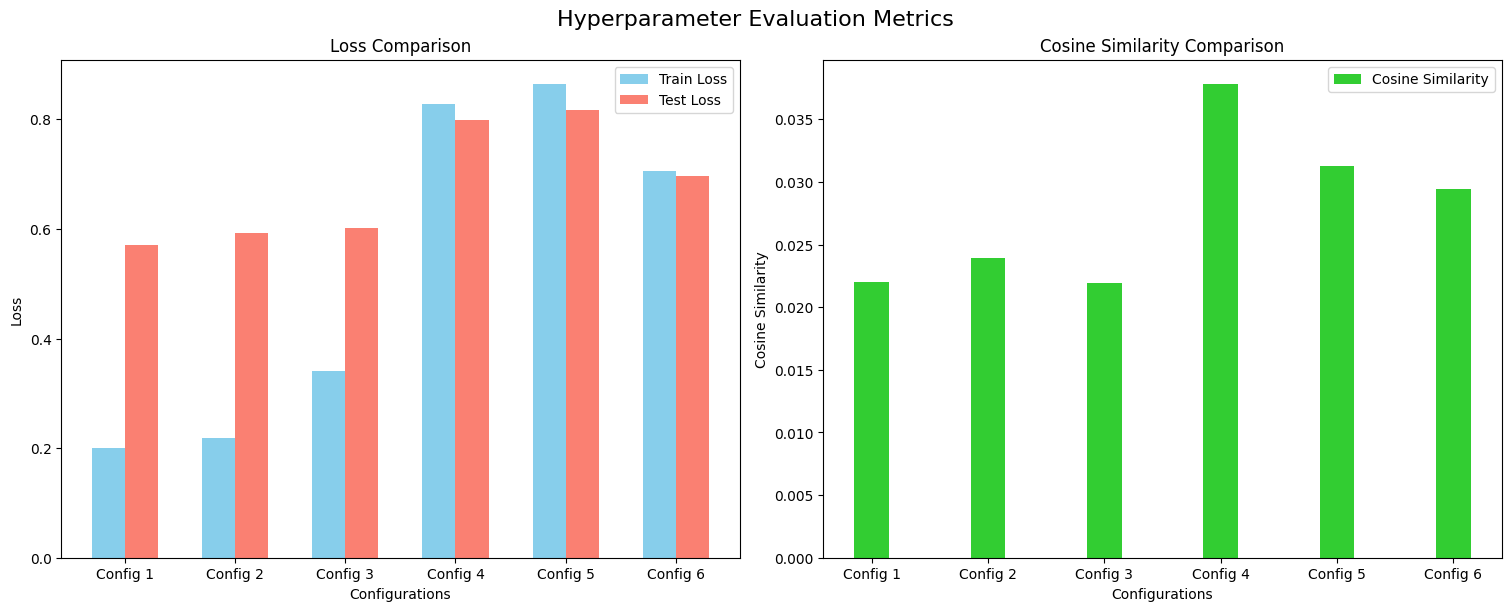

Best configuration in terms of test loss : {'config': {'hidden_dim1': 256, 'hidden_dim2': 128, 'learning_rate': 0.001, 'batch_size': 64}, 'final_train_loss': 0.20002157183793876, 'final_test_loss': 0.5713936984539032, 'cosine_similarity': np.float32(0.021994466)}
Best configuration in terms of cosine similarity : {'config': {'hidden_dim1': 128, 'hidden_dim2': 64, 'learning_rate': 0.001, 'batch_size': 64}, 'final_train_loss': 0.3413071105113396, 'final_test_loss': 0.6019654721021652, 'cosine_similarity': np.float32(0.021956038)}


In [28]:
# Visualization
results = best_results
labels = [f"Config {i+1}" for i in range(len(results))]
train_losses = [res['final_train_loss'] for res in results]
test_losses = [res['final_test_loss'] for res in results]
similarities = [res['cosine_similarity'] for res in results]

x = np.arange(len(labels))  # Label locations
width = 0.3  # Bar width

fig, ax = plt.subplots(1, 2, figsize=(15, 6), constrained_layout=True)

# Bar plot for Losses
ax[0].bar(x - width/2, train_losses, width, label='Train Loss', color='skyblue')
ax[0].bar(x + width/2, test_losses, width, label='Test Loss', color='salmon')
ax[0].set_title('Loss Comparison')
ax[0].set_xlabel('Configurations')
ax[0].set_ylabel('Loss')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)
ax[0].legend()

# Bar plot for Cosine Similarity
ax[1].bar(x, similarities, width, label='Cosine Similarity', color='limegreen')
ax[1].set_title('Cosine Similarity Comparison')
ax[1].set_xlabel('Configurations')
ax[1].set_ylabel('Cosine Similarity')
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels)
ax[1].legend()

plt.suptitle('Hyperparameter Evaluation Metrics', fontsize=16)
plt.show()

# Find the best configuration
best_config = min(results, key=lambda x: x['final_test_loss'])
second_best_config = min(results, key=lambda x: x['cosine_similarity'])
print(f"Best configuration in terms of test loss : {best_config}")
print(f"Best configuration in terms of cosine similarity : {second_best_config}")

We observe very close cosine similarity for the two best results : ~0.020 and ~0.019 => 0.001 of difference
We also observe very close test loss for both : ~0.567 and ~0.585 => 0.018 of difference.

A factor 10 between both differences, hence we will choose the test loss as our criteria.

#### Finally, the best configuration is : hidden_dim1 = 256, hidden_dim2 = 128, learning_rate = 0.001, batch_size = 64

Another way to confirm that it is the best configuration, is to not define any seed for the data split and the batching, in order to leave some randomness between different trainings, and then execute the loop that comes before many times to check which configuration is consistantly in the best two. And it is indeed the 'hidden_dim1 = 256, hidden_dim2 = 128, learning_rate = 0.001, batch_size = 64' one.

## Conclusion

In this notebook, we documented the steps for hyperparameter tuning of the AutoEncoder.

Thanks to this, we know that the best configuration to train our AutoEncoder with is the following :

### hidden_dim1 = 256, hidden_dim2 = 128, learning_rate = 0.001, batch_size = 64